In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import DataLoader

plt.ion()   # interactive mode

In [2]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

                               
trainset_only_bg_b = datasets.ImageFolder("data/only_bg_b/train", transform=transform)
testset_only_bg_b = datasets.ImageFolder("data/only_bg_b/val", transform=transform)
testset_original = datasets.ImageFolder("data/original/val", transform=transform)


dataloaders={"trainset_only_bg_b":DataLoader(trainset_only_bg_b, batch_size=64, shuffle=True),
             "testset_only_bg_b":DataLoader(testset_only_bg_b, batch_size=64, shuffle=True),
             "testset_original":DataLoader(testset_original, batch_size=64, shuffle=True)}

dataset_sizes={"trainset_only_bg_b": len(trainset_only_bg_b),
               "testset_only_bg_b": len(testset_only_bg_b),
               "testset_original": len(testset_original)}

class_names=trainset_only_bg_b.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\gerasimos\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


# Visualize a few images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


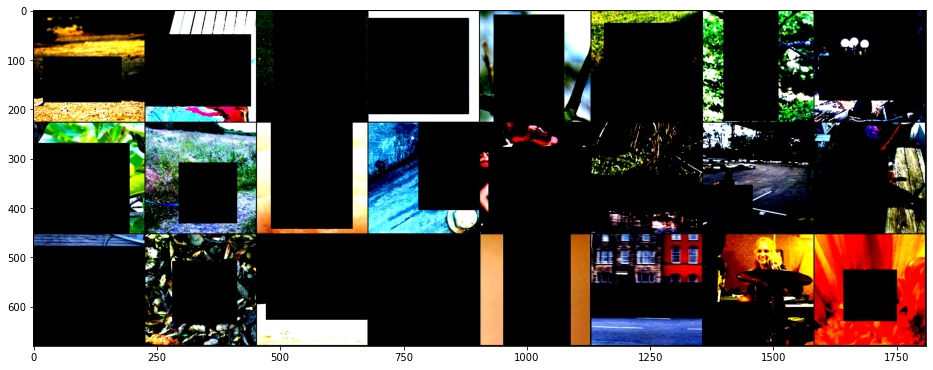

In [21]:
samples, labels = iter(dataloaders['trainset_only_bg_b']).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

# Training the model

In [17]:
def train_model(model, criterion, optimizer, num_epochs=3):
    #since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ["trainset_only_bg_b", "testset_only_bg_b", "testset_original"]:
            if phase == "trainset_only_bg_b":
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "trainset_only_bg_b"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == "trainset_only_bg_b":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == "testset_only_bg_b" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    #time_elapsed = time.time() - since
    #print('Training complete in {:.0f}m {:.0f}s'.format(
        #time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# ResNet 18

In [15]:
model_conv = models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 9) #9 classes

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv, num_epochs=4)

Epoch 0/3
----------
trainset_only_bg_b Loss: 1.5129 Acc: 0.4691
testset_only_bg_b Loss: 1.5301 Acc: 0.4612
testset_original Loss: 1.1828 Acc: 0.6183

Epoch 1/3
----------
trainset_only_bg_b Loss: 1.3713 Acc: 0.5184
testset_only_bg_b Loss: 1.4936 Acc: 0.4728
testset_original Loss: 1.1489 Acc: 0.6264

Epoch 2/3
----------
trainset_only_bg_b Loss: 1.3468 Acc: 0.5291
testset_only_bg_b Loss: 1.5014 Acc: 0.4649
testset_original Loss: 1.2221 Acc: 0.5852

Epoch 3/3
----------
trainset_only_bg_b Loss: 1.3347 Acc: 0.5314
testset_only_bg_b Loss: 1.5214 Acc: 0.4622
testset_original Loss: 1.1668 Acc: 0.6202



NameError: name 'since' is not defined

# ResNet 50

In [18]:
model_conv = models.resnet50(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 9) #9 classes

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\gerasimos/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth


In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv, num_epochs=3)

Epoch 0/2
----------
trainset_only_bg_b Loss: 1.4164 Acc: 0.5052
testset_only_bg_b Loss: 1.5127 Acc: 0.4778
testset_original Loss: 1.1433 Acc: 0.6069

Epoch 1/2
----------


KeyboardInterrupt: 